# TD(0)
* Buggy -- no learning. 

In [1]:
import gym
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
env = gym.make('CartPole-v0')
gamma = 0.99

input_dim  = 4
action_dim = 2
hidden_dim = 128 

class AgentNetwork(tf.keras.Model):
    
    def __init__(self, action_dim, hidden_dim):
        super().__init__()
        
        self.hidden = layers.Dense(hidden_dim, activation='relu')
        self.actor  = layers.Dense(action_dim, activation='softmax')
        self.critic = layers.Dense(1)
        
    def call(self, inputs):
        # actor and critic share the same hidden layer
        x = self.hidden(inputs)
        return self.actor(x), self.critic(x)
    
adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
huber_loss = keras.losses.Huber()
model = AgentNetwork(2, 128)

MAX_EPISODE_LENGTH = 1000
eps = 0.1

def run_episode(env, state, model, optimizer, gamma):
    
    action_prob_history  = []
    critic_value_history = []
    reward_history       = []
    
    I = 1
    
    for step in range(1, MAX_EPISODE_LENGTH):
        with tf.GradientTape() as tape:
            state = tf.convert_to_tensor([state])

            action_probs, state_value = model(state)
            action_index = np.random.choice(action_dim, p=np.squeeze(action_probs))
            action_prob = action_probs[0, action_index]
        
            next_state, reward, done, _ = env.step(action_index)
            reward_history.append(reward)
            
            _, next_state_value = model(tf.convert_to_tensor([next_state]))
            
            td_target = reward + gamma* next_state_value
            td_error =  td_target - state_value

            actor_loss = td_error * tf.math.log(action_prob) * I
            critic_loss = td_error * state_value * I

            loss = actor_loss + critic_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            state = next_state
#             I *= gamma

        if done:
            break
        
    return reward_history
    
def train():
    
    episode_count = 0
    running_reward = 0
    episode_rewards = []
    
    while True:

        init_state = env.reset()        
        reward_history = run_episode(env, init_state, model, adam_optimizer, gamma)
        
        episode_reward = tf.math.reduce_sum(reward_history)
        episode_rewards.append(episode_reward)
        
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
        # Log details
        episode_count += 1
        if episode_count % 10 == 0:
            template = "running reward: {:.2f} at episode {}"
            print(template.format(running_reward, episode_count))
        if running_reward > 180:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break
        
        

    plt.plot(episode_rewards, label='episode rewards')
    
    running_avg = [np.average(episode_rewards[:i+1]) for i in range(len(episode_rewards))]
    running_avg_100 = running_avg[:100] + [np.average(episode_rewards[i:i+100]) for i in range(len(episode_rewards)-100)]
    
    plt.plot(running_avg, label='average reward')
    plt.plot(running_avg_100, label='average reward of past 100 episodes')
    plt.legend()
    plt.show()
    
train()

running reward: 15.07 at episode 10
running reward: 33.81 at episode 20
running reward: 37.94 at episode 30
running reward: 46.71 at episode 40
running reward: 43.58 at episode 50
running reward: 47.95 at episode 60
running reward: 47.95 at episode 70
running reward: 44.89 at episode 80
running reward: 39.78 at episode 90
running reward: 51.27 at episode 100
running reward: 54.03 at episode 110
running reward: 46.81 at episode 120
running reward: 60.86 at episode 130
running reward: 63.74 at episode 140
running reward: 50.29 at episode 150
running reward: 44.75 at episode 160
running reward: 50.92 at episode 170
running reward: 53.15 at episode 180
running reward: 55.38 at episode 190
running reward: 52.20 at episode 200
running reward: 49.82 at episode 210
running reward: 50.25 at episode 220
running reward: 40.58 at episode 230
running reward: 38.85 at episode 240
running reward: 43.71 at episode 250
running reward: 43.46 at episode 260
running reward: 37.40 at episode 270
running re

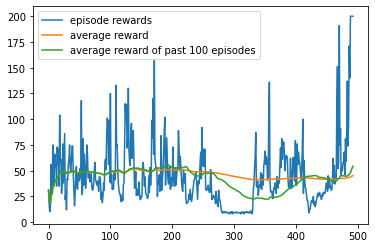

In [5]:
env = gym.make('CartPole-v0')
gamma = 0.99

input_dim  = 4
action_dim = 2
hidden_dim = 164

class ActorNetwork(tf.keras.Model):
    
    def __init__(self, action_dim, hidden_dim):
        super().__init__()
        
        self.hidden = layers.Dense(hidden_dim, activation='relu')
        self.actor  = layers.Dense(action_dim, activation='softmax')
        
    def call(self, inputs):
        # actor and critic share the same hidden layer
        x = self.hidden(inputs)
        return self.actor(x)
    
    def update(self, loss):
        grads = tape.gradient(-loss, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

class CriticNetwork(tf.keras.Model):
    
    def __init__(self, action_dim, hidden_dim):
        super().__init__()
        
        self.hidden = layers.Dense(hidden_dim, activation='relu')
        self.critic = layers.Dense(1)
        
    def call(self, inputs):
        x = self.hidden(inputs)
        return self.critic(x)
        

optimizer_actor = keras.optimizers.Adam(learning_rate=0.003)
optimizer_critic = keras.optimizers.Adam(learning_rate=0.003)

actor_model = ActorNetwork(2, 128)
critic_model = CriticNetwork(2, 128)

MAX_EPISODE_LENGTH = 1000
eps = 0.1

def run_episode(env, state, gamma):
    
    action_prob_history  = []
    critic_value_history = []
    reward_history       = []
    
    I = 1
    
    for step in range(1, MAX_EPISODE_LENGTH):
        with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
            state = tf.convert_to_tensor([state])

            action_probs = actor_model(state)
            state_value  = critic_model(state)
            
            action_index = np.random.choice(action_dim, p=np.squeeze(action_probs))
            action_prob = action_probs[0, action_index]

            next_state, reward, done, _ = env.step(action_index)
            reward_history.append(reward)
            
            next_state_value = critic_model(tf.convert_to_tensor([next_state]))
            delta = reward + gamma* next_state_value - state_value

            actor_loss = delta * tf.math.log(action_prob)
            critic_loss = delta * state_value
            
            actor_grads = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
            critic_grads = tape_critic.gradient(-critic_loss, critic_model.trainable_variables)
 
            optimizer_actor.apply_gradients(zip(actor_grads, actor_model.trainable_variables))
            optimizer_critic.apply_gradients(zip(critic_grads, critic_model.trainable_variables))
            
            state = next_state

        if done:
            break
        
    return reward_history
    
def train():
    
    episode_count = 0
    running_reward = 0
    episode_rewards = []
    
    while True:

        init_state = env.reset()        
        reward_history = run_episode(env, init_state, gamma)
        
        episode_reward = tf.math.reduce_sum(reward_history)
        episode_rewards.append(episode_reward)
        
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
        # Log details
        episode_count += 1
        if episode_count % 10 == 0:
            template = "running reward: {:.2f} at episode {}"
            print(template.format(running_reward, episode_count))
        if running_reward > 150:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break
        
        

    plt.plot(episode_rewards, label='episode rewards')
    
    running_avg = [np.average(episode_rewards[:i+1]) for i in range(len(episode_rewards))]
    running_avg_100 = running_avg[:100] + [np.average(episode_rewards[i:i+100]) for i in range(len(episode_rewards)-100)]
    
    plt.plot(running_avg, label='average reward')
    plt.plot(running_avg_100, label='average reward of past 100 episodes')
    plt.legend()
    plt.show()
    
train()